# Chronos-2 Foundation Model
In this notebook, we will show how to use Chronos-2 in Darts. If you are new to Darts, please check out the [Quickstart Guide](https://unit8co.github.io/darts/quickstart/00-quickstart.html) before proceeding.

Chronos-2 is a time series foundation model for zero-shot forecasting. That means that it can be used for forecasting **without any training or fine-tuning** since it has already been pre-trained on large-scale time series data. Chronos-2 supports multivariate time series forecasting with [covariates](https://unit8co.github.io/darts/userguide/covariates.html) (exogenous variables) and can produce probabilistic forecasts.

Check out the [Amazon Science Blog](https://www.amazon.science/blog/introducing-chronos-2-from-univariate-to-universal-forecasting) and the [original paper](https://arxiv.org/abs/2510.15821) for technical details.

<div class="alert alert-success" role="alert">
  Fine-tuning Chronos-2 on your own data is not yet supported in Darts, but may be added in the future.
</div>

In [1]:
# fix python path if working locally
from utils import fix_pythonpath_if_working_locally

fix_pythonpath_if_working_locally()
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import warnings

import numpy as np

from darts.datasets import AirPassengersDataset
from darts.models import Chronos2Model

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)

## Data Preparation

Here, we will use the [Electricity Consumption Zurich Dataset](https://unit8co.github.io/darts/generated_api/darts.datasets.html#darts.datasets.ElectricityConsumptionZurichDataset), which records the electricity consumption of households & SMEs (`"Value_NE5"` column) and business & services (`"Value_NE7"`) in Zurich, Switzerland, along with weather covariates such as temperature (`"T [°C]"`) and humidity (`"Hr [%Hr]"`).
Values are recorded every 15 minutes between January 2015 and August 2022.

<details>

<summary><strong>Train-Test Split</strong></summary>

Even though Chronos-2 is pre-trained already, we still need to split the data into training and test sets. That is because `Chronos2Model` follows the Darts unified interface and will require calling the `fit()` method before forecasting. However, no training or fine-tuning will be performed during the `fit()` call.

</details>

<details>

<summary><strong>Data Scaling</strong></summary>

Unlike other deep learning models in Darts, Chronos-2 does not require data scaling since it has its own internal data normalization mechanism. Therefore, we will skip the scaling step in this notebook.

</details>

In [4]:
# convert to float32 as Chronos-2 works with float32 input
data = AirPassengersDataset().load().astype(np.float32)
# extract households energy consumption
# ts_energy = data["Value_NE5"]
# # extract temperature, solar irradiation and rain duration
# ts_weather = data[["T [°C]", "StrGlo [W/m2]", "RainDur [min]"]]
# # split into train and validation sets by last 7 days
train_passengers, val_passengers = data.split_before(len(data) - 2 * 12)

In [5]:
val_passengers

,#Passengers
Month,
1959-01-01,360.0
1959-02-01,342.0
1959-03-01,406.0
1959-04-01,396.0
1959-05-01,420.0
...,...
1960-08-01,606.0
1960-09-01,508.0
1960-10-01,461.0


Let's quickly visualize the last 7 days of the electricity consumption data.

<Axes: xlabel='Month'>

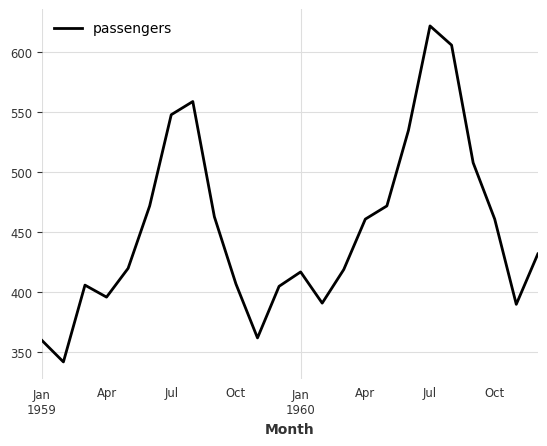

In [6]:
val_passengers.plot(label="passengers")

# Full fine-tuning

In [10]:
model = Chronos2Model(
    input_chunk_length=12,
    output_chunk_length=6,
    enable_finetuning=True,
    n_epochs=10,
)
model.fit(train_passengers, verbose=True)
model.save("full_finetuned.pt")

# Load
loaded = Chronos2Model.load("full_finetuned.pt")

Training: |          | 0/? [00:00<?, ?it/s]

# Partial fine-tuning with layer freezing

In [14]:
from darts.models.forecasting.foundation_model import LayerFreezeCallback

freeze_callback = LayerFreezeCallback(
    freeze_patterns=["encoder.block.0", "encoder.block.1", "encoder.block.2"],
    unfreeze_patterns=["output_patch_embedding"],
)

model = Chronos2Model(
    input_chunk_length=12,
    output_chunk_length=6,
    enable_finetuning=True,
    n_epochs=10,
    pl_trainer_kwargs={"callbacks": [freeze_callback]},
)
model.fit(train_passengers, verbose=True)
model.save("partial_finetuned.pt")

# Load - no callback needed, structure unchanged
loaded = Chronos2Model.load("partial_finetuned.pt")

Model transformed. Trainable: 72,280,224/119,477,664 (60.50%)


Training: |          | 0/? [00:00<?, ?it/s]

# LoRA fine-tuning

In [6]:
from peft import LoraConfig

from darts.models.forecasting.foundation_model import PeftCallback

lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["q", "v"],
    lora_dropout=0.1,
)
peft_callback = PeftCallback(peft_config=lora_config)

model = Chronos2Model(
    input_chunk_length=12,
    output_chunk_length=6,
    enable_finetuning=True,
    n_epochs=10,
    pl_trainer_kwargs={"callbacks": [peft_callback]},
)
model.fit(train_passengers, verbose=True)

# model.save("chronos2_lora_finetuned.pt")
# # Save adapters using PEFT's native method
# model.model.model.save_pretrained("chronos2_lora_adapters/")

# # === Loading ===
# # Use callback with adapter_path to load
# load_callback = PeftCallback(adapter_path="chronos2_lora_adapters/")

# loaded = Chronos2Model.load("chronos2_lora_finetuned.pt")
# loaded.fit(train_passengers[:1])  # Initialize model structure
# loaded.predict(n=12, series=train_passengers)  # Adapters applied via on_predict_start

Model transformed. Trainable: 1,179,648/120,657,312 (0.98%)


Training: |          | 0/? [00:00<?, ?it/s]

Chronos2Model(output_chunk_shift=0, likelihood=None, hub_model_name=amazon/chronos-2, hub_model_revision=None, local_dir=None, input_chunk_length=12, output_chunk_length=6, enable_finetuning=True, n_epochs=10, pl_trainer_kwargs={'callbacks': [<darts.models.forecasting.foundation_model.PeftCallback object at 0x115600410>]})

In [7]:
model.save("chronos2_lora_finetuned.pt")

In [14]:
loaded = Chronos2Model.load(
    "chronos2_lora_finetuned.pt", pl_trainer_kwargs={"callbacks": [peft_callback]}
)

RuntimeError: Error(s) in loading state_dict for _Chronos2PLModule:
	Missing key(s) in state_dict: "model.shared.weight", "model.input_patch_embedding.hidden_layer.weight", "model.input_patch_embedding.hidden_layer.bias", "model.input_patch_embedding.output_layer.weight", "model.input_patch_embedding.output_layer.bias", "model.input_patch_embedding.residual_layer.weight", "model.input_patch_embedding.residual_layer.bias", "model.encoder.block.0.layer.0.self_attention.q.weight", "model.encoder.block.0.layer.0.self_attention.k.weight", "model.encoder.block.0.layer.0.self_attention.v.weight", "model.encoder.block.0.layer.0.self_attention.o.weight", "model.encoder.block.0.layer.0.layer_norm.weight", "model.encoder.block.0.layer.1.self_attention.q.weight", "model.encoder.block.0.layer.1.self_attention.k.weight", "model.encoder.block.0.layer.1.self_attention.v.weight", "model.encoder.block.0.layer.1.self_attention.o.weight", "model.encoder.block.0.layer.1.layer_norm.weight", "model.encoder.block.0.layer.2.mlp.wi.weight", "model.encoder.block.0.layer.2.mlp.wo.weight", "model.encoder.block.0.layer.2.layer_norm.weight", "model.encoder.block.1.layer.0.self_attention.q.weight", "model.encoder.block.1.layer.0.self_attention.k.weight", "model.encoder.block.1.layer.0.self_attention.v.weight", "model.encoder.block.1.layer.0.self_attention.o.weight", "model.encoder.block.1.layer.0.layer_norm.weight", "model.encoder.block.1.layer.1.self_attention.q.weight", "model.encoder.block.1.layer.1.self_attention.k.weight", "model.encoder.block.1.layer.1.self_attention.v.weight", "model.encoder.block.1.layer.1.self_attention.o.weight", "model.encoder.block.1.layer.1.layer_norm.weight", "model.encoder.block.1.layer.2.mlp.wi.weight", "model.encoder.block.1.layer.2.mlp.wo.weight", "model.encoder.block.1.layer.2.layer_norm.weight", "model.encoder.block.2.layer.0.self_attention.q.weight", "model.encoder.block.2.layer.0.self_attention.k.weight", "model.encoder.block.2.layer.0.self_attention.v.weight", "model.encoder.block.2.layer.0.self_attention.o.weight", "model.encoder.block.2.layer.0.layer_norm.weight", "model.encoder.block.2.layer.1.self_attention.q.weight", "model.encoder.block.2.layer.1.self_attention.k.weight", "model.encoder.block.2.layer.1.self_attention.v.weight", "model.encoder.block.2.layer.1.self_attention.o.weight", "model.encoder.block.2.layer.1.layer_norm.weight", "model.encoder.block.2.layer.2.mlp.wi.weight", "model.encoder.block.2.layer.2.mlp.wo.weight", "model.encoder.block.2.layer.2.layer_norm.weight", "model.encoder.block.3.layer.0.self_attention.q.weight", "model.encoder.block.3.layer.0.self_attention.k.weight", "model.encoder.block.3.layer.0.self_attention.v.weight", "model.encoder.block.3.layer.0.self_attention.o.weight", "model.encoder.block.3.layer.0.layer_norm.weight", "model.encoder.block.3.layer.1.self_attention.q.weight", "model.encoder.block.3.layer.1.self_attention.k.weight", "model.encoder.block.3.layer.1.self_attention.v.weight", "model.encoder.block.3.layer.1.self_attention.o.weight", "model.encoder.block.3.layer.1.layer_norm.weight", "model.encoder.block.3.layer.2.mlp.wi.weight", "model.encoder.block.3.layer.2.mlp.wo.weight", "model.encoder.block.3.layer.2.layer_norm.weight", "model.encoder.block.4.layer.0.self_attention.q.weight", "model.encoder.block.4.layer.0.self_attention.k.weight", "model.encoder.block.4.layer.0.self_attention.v.weight", "model.encoder.block.4.layer.0.self_attention.o.weight", "model.encoder.block.4.layer.0.layer_norm.weight", "model.encoder.block.4.layer.1.self_attention.q.weight", "model.encoder.block.4.layer.1.self_attention.k.weight", "model.encoder.block.4.layer.1.self_attention.v.weight", "model.encoder.block.4.layer.1.self_attention.o.weight", "model.encoder.block.4.layer.1.layer_norm.weight", "model.encoder.block.4.layer.2.mlp.wi.weight", "model.encoder.block.4.layer.2.mlp.wo.weight", "model.encoder.block.4.layer.2.layer_norm.weight", "model.encoder.block.5.layer.0.self_attention.q.weight", "model.encoder.block.5.layer.0.self_attention.k.weight", "model.encoder.block.5.layer.0.self_attention.v.weight", "model.encoder.block.5.layer.0.self_attention.o.weight", "model.encoder.block.5.layer.0.layer_norm.weight", "model.encoder.block.5.layer.1.self_attention.q.weight", "model.encoder.block.5.layer.1.self_attention.k.weight", "model.encoder.block.5.layer.1.self_attention.v.weight", "model.encoder.block.5.layer.1.self_attention.o.weight", "model.encoder.block.5.layer.1.layer_norm.weight", "model.encoder.block.5.layer.2.mlp.wi.weight", "model.encoder.block.5.layer.2.mlp.wo.weight", "model.encoder.block.5.layer.2.layer_norm.weight", "model.encoder.block.6.layer.0.self_attention.q.weight", "model.encoder.block.6.layer.0.self_attention.k.weight", "model.encoder.block.6.layer.0.self_attention.v.weight", "model.encoder.block.6.layer.0.self_attention.o.weight", "model.encoder.block.6.layer.0.layer_norm.weight", "model.encoder.block.6.layer.1.self_attention.q.weight", "model.encoder.block.6.layer.1.self_attention.k.weight", "model.encoder.block.6.layer.1.self_attention.v.weight", "model.encoder.block.6.layer.1.self_attention.o.weight", "model.encoder.block.6.layer.1.layer_norm.weight", "model.encoder.block.6.layer.2.mlp.wi.weight", "model.encoder.block.6.layer.2.mlp.wo.weight", "model.encoder.block.6.layer.2.layer_norm.weight", "model.encoder.block.7.layer.0.self_attention.q.weight", "model.encoder.block.7.layer.0.self_attention.k.weight", "model.encoder.block.7.layer.0.self_attention.v.weight", "model.encoder.block.7.layer.0.self_attention.o.weight", "model.encoder.block.7.layer.0.layer_norm.weight", "model.encoder.block.7.layer.1.self_attention.q.weight", "model.encoder.block.7.layer.1.self_attention.k.weight", "model.encoder.block.7.layer.1.self_attention.v.weight", "model.encoder.block.7.layer.1.self_attention.o.weight", "model.encoder.block.7.layer.1.layer_norm.weight", "model.encoder.block.7.layer.2.mlp.wi.weight", "model.encoder.block.7.layer.2.mlp.wo.weight", "model.encoder.block.7.layer.2.layer_norm.weight", "model.encoder.block.8.layer.0.self_attention.q.weight", "model.encoder.block.8.layer.0.self_attention.k.weight", "model.encoder.block.8.layer.0.self_attention.v.weight", "model.encoder.block.8.layer.0.self_attention.o.weight", "model.encoder.block.8.layer.0.layer_norm.weight", "model.encoder.block.8.layer.1.self_attention.q.weight", "model.encoder.block.8.layer.1.self_attention.k.weight", "model.encoder.block.8.layer.1.self_attention.v.weight", "model.encoder.block.8.layer.1.self_attention.o.weight", "model.encoder.block.8.layer.1.layer_norm.weight", "model.encoder.block.8.layer.2.mlp.wi.weight", "model.encoder.block.8.layer.2.mlp.wo.weight", "model.encoder.block.8.layer.2.layer_norm.weight", "model.encoder.block.9.layer.0.self_attention.q.weight", "model.encoder.block.9.layer.0.self_attention.k.weight", "model.encoder.block.9.layer.0.self_attention.v.weight", "model.encoder.block.9.layer.0.self_attention.o.weight", "model.encoder.block.9.layer.0.layer_norm.weight", "model.encoder.block.9.layer.1.self_attention.q.weight", "model.encoder.block.9.layer.1.self_attention.k.weight", "model.encoder.block.9.layer.1.self_attention.v.weight", "model.encoder.block.9.layer.1.self_attention.o.weight", "model.encoder.block.9.layer.1.layer_norm.weight", "model.encoder.block.9.layer.2.mlp.wi.weight", "model.encoder.block.9.layer.2.mlp.wo.weight", "model.encoder.block.9.layer.2.layer_norm.weight", "model.encoder.block.10.layer.0.self_attention.q.weight", "model.encoder.block.10.layer.0.self_attention.k.weight", "model.encoder.block.10.layer.0.self_attention.v.weight", "model.encoder.block.10.layer.0.self_attention.o.weight", "model.encoder.block.10.layer.0.layer_norm.weight", "model.encoder.block.10.layer.1.self_attention.q.weight", "model.encoder.block.10.layer.1.self_attention.k.weight", "model.encoder.block.10.layer.1.self_attention.v.weight", "model.encoder.block.10.layer.1.self_attention.o.weight", "model.encoder.block.10.layer.1.layer_norm.weight", "model.encoder.block.10.layer.2.mlp.wi.weight", "model.encoder.block.10.layer.2.mlp.wo.weight", "model.encoder.block.10.layer.2.layer_norm.weight", "model.encoder.block.11.layer.0.self_attention.q.weight", "model.encoder.block.11.layer.0.self_attention.k.weight", "model.encoder.block.11.layer.0.self_attention.v.weight", "model.encoder.block.11.layer.0.self_attention.o.weight", "model.encoder.block.11.layer.0.layer_norm.weight", "model.encoder.block.11.layer.1.self_attention.q.weight", "model.encoder.block.11.layer.1.self_attention.k.weight", "model.encoder.block.11.layer.1.self_attention.v.weight", "model.encoder.block.11.layer.1.self_attention.o.weight", "model.encoder.block.11.layer.1.layer_norm.weight", "model.encoder.block.11.layer.2.mlp.wi.weight", "model.encoder.block.11.layer.2.mlp.wo.weight", "model.encoder.block.11.layer.2.layer_norm.weight", "model.encoder.final_layer_norm.weight", "model.output_patch_embedding.hidden_layer.weight", "model.output_patch_embedding.hidden_layer.bias", "model.output_patch_embedding.output_layer.weight", "model.output_patch_embedding.output_layer.bias", "model.output_patch_embedding.residual_layer.weight", "model.output_patch_embedding.residual_layer.bias". 
	Unexpected key(s) in state_dict: "model.base_model.model.shared.weight", "model.base_model.model.input_patch_embedding.hidden_layer.weight", "model.base_model.model.input_patch_embedding.hidden_layer.bias", "model.base_model.model.input_patch_embedding.output_layer.weight", "model.base_model.model.input_patch_embedding.output_layer.bias", "model.base_model.model.input_patch_embedding.residual_layer.weight", "model.base_model.model.input_patch_embedding.residual_layer.bias", "model.base_model.model.encoder.block.0.layer.0.self_attention.q.base_layer.weight", "model.base_model.model.encoder.block.0.layer.0.self_attention.q.lora_A.default.weight", "model.base_model.model.encoder.block.0.layer.0.self_attention.q.lora_B.default.weight", "model.base_model.model.encoder.block.0.layer.0.self_attention.k.weight", "model.base_model.model.encoder.block.0.layer.0.self_attention.v.base_layer.weight", "model.base_model.model.encoder.block.0.layer.0.self_attention.v.lora_A.default.weight", "model.base_model.model.encoder.block.0.layer.0.self_attention.v.lora_B.default.weight", "model.base_model.model.encoder.block.0.layer.0.self_attention.o.weight", "model.base_model.model.encoder.block.0.layer.0.layer_norm.weight", "model.base_model.model.encoder.block.0.layer.1.self_attention.q.base_layer.weight", "model.base_model.model.encoder.block.0.layer.1.self_attention.q.lora_A.default.weight", "model.base_model.model.encoder.block.0.layer.1.self_attention.q.lora_B.default.weight", "model.base_model.model.encoder.block.0.layer.1.self_attention.k.weight", "model.base_model.model.encoder.block.0.layer.1.self_attention.v.base_layer.weight", "model.base_model.model.encoder.block.0.layer.1.self_attention.v.lora_A.default.weight", "model.base_model.model.encoder.block.0.layer.1.self_attention.v.lora_B.default.weight", "model.base_model.model.encoder.block.0.layer.1.self_attention.o.weight", "model.base_model.model.encoder.block.0.layer.1.layer_norm.weight", "model.base_model.model.encoder.block.0.layer.2.mlp.wi.weight", "model.base_model.model.encoder.block.0.layer.2.mlp.wo.weight", "model.base_model.model.encoder.block.0.layer.2.layer_norm.weight", "model.base_model.model.encoder.block.1.layer.0.self_attention.q.base_layer.weight", "model.base_model.model.encoder.block.1.layer.0.self_attention.q.lora_A.default.weight", "model.base_model.model.encoder.block.1.layer.0.self_attention.q.lora_B.default.weight", "model.base_model.model.encoder.block.1.layer.0.self_attention.k.weight", "model.base_model.model.encoder.block.1.layer.0.self_attention.v.base_layer.weight", "model.base_model.model.encoder.block.1.layer.0.self_attention.v.lora_A.default.weight", "model.base_model.model.encoder.block.1.layer.0.self_attention.v.lora_B.default.weight", "model.base_model.model.encoder.block.1.layer.0.self_attention.o.weight", "model.base_model.model.encoder.block.1.layer.0.layer_norm.weight", "model.base_model.model.encoder.block.1.layer.1.self_attention.q.base_layer.weight", "model.base_model.model.encoder.block.1.layer.1.self_attention.q.lora_A.default.weight", "model.base_model.model.encoder.block.1.layer.1.self_attention.q.lora_B.default.weight", "model.base_model.model.encoder.block.1.layer.1.self_attention.k.weight", "model.base_model.model.encoder.block.1.layer.1.self_attention.v.base_layer.weight", "model.base_model.model.encoder.block.1.layer.1.self_attention.v.lora_A.default.weight", "model.base_model.model.encoder.block.1.layer.1.self_attention.v.lora_B.default.weight", "model.base_model.model.encoder.block.1.layer.1.self_attention.o.weight", "model.base_model.model.encoder.block.1.layer.1.layer_norm.weight", "model.base_model.model.encoder.block.1.layer.2.mlp.wi.weight", "model.base_model.model.encoder.block.1.layer.2.mlp.wo.weight", "model.base_model.model.encoder.block.1.layer.2.layer_norm.weight", "model.base_model.model.encoder.block.2.layer.0.self_attention.q.base_layer.weight", "model.base_model.model.encoder.block.2.layer.0.self_attention.q.lora_A.default.weight", "model.base_model.model.encoder.block.2.layer.0.self_attention.q.lora_B.default.weight", "model.base_model.model.encoder.block.2.layer.0.self_attention.k.weight", "model.base_model.model.encoder.block.2.layer.0.self_attention.v.base_layer.weight", "model.base_model.model.encoder.block.2.layer.0.self_attention.v.lora_A.default.weight", "model.base_model.model.encoder.block.2.layer.0.self_attention.v.lora_B.default.weight", "model.base_model.model.encoder.block.2.layer.0.self_attention.o.weight", "model.base_model.model.encoder.block.2.layer.0.layer_norm.weight", "model.base_model.model.encoder.block.2.layer.1.self_attention.q.base_layer.weight", "model.base_model.model.encoder.block.2.layer.1.self_attention.q.lora_A.default.weight", "model.base_model.model.encoder.block.2.layer.1.self_attention.q.lora_B.default.weight", "model.base_model.model.encoder.block.2.layer.1.self_attention.k.weight", "model.base_model.model.encoder.block.2.layer.1.self_attention.v.base_layer.weight", "model.base_model.model.encoder.block.2.layer.1.self_attention.v.lora_A.default.weight", "model.base_model.model.encoder.block.2.layer.1.self_attention.v.lora_B.default.weight", "model.base_model.model.encoder.block.2.layer.1.self_attention.o.weight", "model.base_model.model.encoder.block.2.layer.1.layer_norm.weight", "model.base_model.model.encoder.block.2.layer.2.mlp.wi.weight", "model.base_model.model.encoder.block.2.layer.2.mlp.wo.weight", "model.base_model.model.encoder.block.2.layer.2.layer_norm.weight", "model.base_model.model.encoder.block.3.layer.0.self_attention.q.base_layer.weight", "model.base_model.model.encoder.block.3.layer.0.self_attention.q.lora_A.default.weight", "model.base_model.model.encoder.block.3.layer.0.self_attention.q.lora_B.default.weight", "model.base_model.model.encoder.block.3.layer.0.self_attention.k.weight", "model.base_model.model.encoder.block.3.layer.0.self_attention.v.base_layer.weight", "model.base_model.model.encoder.block.3.layer.0.self_attention.v.lora_A.default.weight", "model.base_model.model.encoder.block.3.layer.0.self_attention.v.lora_B.default.weight", "model.base_model.model.encoder.block.3.layer.0.self_attention.o.weight", "model.base_model.model.encoder.block.3.layer.0.layer_norm.weight", "model.base_model.model.encoder.block.3.layer.1.self_attention.q.base_layer.weight", "model.base_model.model.encoder.block.3.layer.1.self_attention.q.lora_A.default.weight", "model.base_model.model.encoder.block.3.layer.1.self_attention.q.lora_B.default.weight", "model.base_model.model.encoder.block.3.layer.1.self_attention.k.weight", "model.base_model.model.encoder.block.3.layer.1.self_attention.v.base_layer.weight", "model.base_model.model.encoder.block.3.layer.1.self_attention.v.lora_A.default.weight", "model.base_model.model.encoder.block.3.layer.1.self_attention.v.lora_B.default.weight", "model.base_model.model.encoder.block.3.layer.1.self_attention.o.weight", "model.base_model.model.encoder.block.3.layer.1.layer_norm.weight", "model.base_model.model.encoder.block.3.layer.2.mlp.wi.weight", "model.base_model.model.encoder.block.3.layer.2.mlp.wo.weight", "model.base_model.model.encoder.block.3.layer.2.layer_norm.weight", "model.base_model.model.encoder.block.4.layer.0.self_attention.q.base_layer.weight", "model.base_model.model.encoder.block.4.layer.0.self_attention.q.lora_A.default.weight", "model.base_model.model.encoder.block.4.layer.0.self_attention.q.lora_B.default.weight", "model.base_model.model.encoder.block.4.layer.0.self_attention.k.weight", "model.base_model.model.encoder.block.4.layer.0.self_attention.v.base_layer.weight", "model.base_model.model.encoder.block.4.layer.0.self_attention.v.lora_A.default.weight", "model.base_model.model.encoder.block.4.layer.0.self_attention.v.lora_B.default.weight", "model.base_model.model.encoder.block.4.layer.0.self_attention.o.weight", "model.base_model.model.encoder.block.4.layer.0.layer_norm.weight", "model.base_model.model.encoder.block.4.layer.1.self_attention.q.base_layer.weight", "model.base_model.model.encoder.block.4.layer.1.self_attention.q.lora_A.default.weight", "model.base_model.model.encoder.block.4.layer.1.self_attention.q.lora_B.default.weight", "model.base_model.model.encoder.block.4.layer.1.self_attention.k.weight", "model.base_model.model.encoder.block.4.layer.1.self_attention.v.base_layer.weight", "model.base_model.model.encoder.block.4.layer.1.self_attention.v.lora_A.default.weight", "model.base_model.model.encoder.block.4.layer.1.self_attention.v.lora_B.default.weight", "model.base_model.model.encoder.block.4.layer.1.self_attention.o.weight", "model.base_model.model.encoder.block.4.layer.1.layer_norm.weight", "model.base_model.model.encoder.block.4.layer.2.mlp.wi.weight", "model.base_model.model.encoder.block.4.layer.2.mlp.wo.weight", "model.base_model.model.encoder.block.4.layer.2.layer_norm.weight", "model.base_model.model.encoder.block.5.layer.0.self_attention.q.base_layer.weight", "model.base_model.model.encoder.block.5.layer.0.self_attention.q.lora_A.default.weight", "model.base_model.model.encoder.block.5.layer.0.self_attention.q.lora_B.default.weight", "model.base_model.model.encoder.block.5.layer.0.self_attention.k.weight", "model.base_model.model.encoder.block.5.layer.0.self_attention.v.base_layer.weight", "model.base_model.model.encoder.block.5.layer.0.self_attention.v.lora_A.default.weight", "model.base_model.model.encoder.block.5.layer.0.self_attention.v.lora_B.default.weight", "model.base_model.model.encoder.block.5.layer.0.self_attention.o.weight", "model.base_model.model.encoder.block.5.layer.0.layer_norm.weight", "model.base_model.model.encoder.block.5.layer.1.self_attention.q.base_layer.weight", "model.base_model.model.encoder.block.5.layer.1.self_attention.q.lora_A.default.weight", "model.base_model.model.encoder.block.5.layer.1.self_attention.q.lora_B.default.weight", "model.base_model.model.encoder.block.5.layer.1.self_attention.k.weight", "model.base_model.model.encoder.block.5.layer.1.self_attention.v.base_layer.weight", "model.base_model.model.encoder.block.5.layer.1.self_attention.v.lora_A.default.weight", "model.base_model.model.encoder.block.5.layer.1.self_attention.v.lora_B.default.weight", "model.base_model.model.encoder.block.5.layer.1.self_attention.o.weight", "model.base_model.model.encoder.block.5.layer.1.layer_norm.weight", "model.base_model.model.encoder.block.5.layer.2.mlp.wi.weight", "model.base_model.model.encoder.block.5.layer.2.mlp.wo.weight", "model.base_model.model.encoder.block.5.layer.2.layer_norm.weight", "model.base_model.model.encoder.block.6.layer.0.self_attention.q.base_layer.weight", "model.base_model.model.encoder.block.6.layer.0.self_attention.q.lora_A.default.weight", "model.base_model.model.encoder.block.6.layer.0.self_attention.q.lora_B.default.weight", "model.base_model.model.encoder.block.6.layer.0.self_attention.k.weight", "model.base_model.model.encoder.block.6.layer.0.self_attention.v.base_layer.weight", "model.base_model.model.encoder.block.6.layer.0.self_attention.v.lora_A.default.weight", "model.base_model.model.encoder.block.6.layer.0.self_attention.v.lora_B.default.weight", "model.base_model.model.encoder.block.6.layer.0.self_attention.o.weight", "model.base_model.model.encoder.block.6.layer.0.layer_norm.weight", "model.base_model.model.encoder.block.6.layer.1.self_attention.q.base_layer.weight", "model.base_model.model.encoder.block.6.layer.1.self_attention.q.lora_A.default.weight", "model.base_model.model.encoder.block.6.layer.1.self_attention.q.lora_B.default.weight", "model.base_model.model.encoder.block.6.layer.1.self_attention.k.weight", "model.base_model.model.encoder.block.6.layer.1.self_attention.v.base_layer.weight", "model.base_model.model.encoder.block.6.layer.1.self_attention.v.lora_A.default.weight", "model.base_model.model.encoder.block.6.layer.1.self_attention.v.lora_B.default.weight", "model.base_model.model.encoder.block.6.layer.1.self_attention.o.weight", "model.base_model.model.encoder.block.6.layer.1.layer_norm.weight", "model.base_model.model.encoder.block.6.layer.2.mlp.wi.weight", "model.base_model.model.encoder.block.6.layer.2.mlp.wo.weight", "model.base_model.model.encoder.block.6.layer.2.layer_norm.weight", "model.base_model.model.encoder.block.7.layer.0.self_attention.q.base_layer.weight", "model.base_model.model.encoder.block.7.layer.0.self_attention.q.lora_A.default.weight", "model.base_model.model.encoder.block.7.layer.0.self_attention.q.lora_B.default.weight", "model.base_model.model.encoder.block.7.layer.0.self_attention.k.weight", "model.base_model.model.encoder.block.7.layer.0.self_attention.v.base_layer.weight", "model.base_model.model.encoder.block.7.layer.0.self_attention.v.lora_A.default.weight", "model.base_model.model.encoder.block.7.layer.0.self_attention.v.lora_B.default.weight", "model.base_model.model.encoder.block.7.layer.0.self_attention.o.weight", "model.base_model.model.encoder.block.7.layer.0.layer_norm.weight", "model.base_model.model.encoder.block.7.layer.1.self_attention.q.base_layer.weight", "model.base_model.model.encoder.block.7.layer.1.self_attention.q.lora_A.default.weight", "model.base_model.model.encoder.block.7.layer.1.self_attention.q.lora_B.default.weight", "model.base_model.model.encoder.block.7.layer.1.self_attention.k.weight", "model.base_model.model.encoder.block.7.layer.1.self_attention.v.base_layer.weight", "model.base_model.model.encoder.block.7.layer.1.self_attention.v.lora_A.default.weight", "model.base_model.model.encoder.block.7.layer.1.self_attention.v.lora_B.default.weight", "model.base_model.model.encoder.block.7.layer.1.self_attention.o.weight", "model.base_model.model.encoder.block.7.layer.1.layer_norm.weight", "model.base_model.model.encoder.block.7.layer.2.mlp.wi.weight", "model.base_model.model.encoder.block.7.layer.2.mlp.wo.weight", "model.base_model.model.encoder.block.7.layer.2.layer_norm.weight", "model.base_model.model.encoder.block.8.layer.0.self_attention.q.base_layer.weight", "model.base_model.model.encoder.block.8.layer.0.self_attention.q.lora_A.default.weight", "model.base_model.model.encoder.block.8.layer.0.self_attention.q.lora_B.default.weight", "model.base_model.model.encoder.block.8.layer.0.self_attention.k.weight", "model.base_model.model.encoder.block.8.layer.0.self_attention.v.base_layer.weight", "model.base_model.model.encoder.block.8.layer.0.self_attention.v.lora_A.default.weight", "model.base_model.model.encoder.block.8.layer.0.self_attention.v.lora_B.default.weight", "model.base_model.model.encoder.block.8.layer.0.self_attention.o.weight", "model.base_model.model.encoder.block.8.layer.0.layer_norm.weight", "model.base_model.model.encoder.block.8.layer.1.self_attention.q.base_layer.weight", "model.base_model.model.encoder.block.8.layer.1.self_attention.q.lora_A.default.weight", "model.base_model.model.encoder.block.8.layer.1.self_attention.q.lora_B.default.weight", "model.base_model.model.encoder.block.8.layer.1.self_attention.k.weight", "model.base_model.model.encoder.block.8.layer.1.self_attention.v.base_layer.weight", "model.base_model.model.encoder.block.8.layer.1.self_attention.v.lora_A.default.weight", "model.base_model.model.encoder.block.8.layer.1.self_attention.v.lora_B.default.weight", "model.base_model.model.encoder.block.8.layer.1.self_attention.o.weight", "model.base_model.model.encoder.block.8.layer.1.layer_norm.weight", "model.base_model.model.encoder.block.8.layer.2.mlp.wi.weight", "model.base_model.model.encoder.block.8.layer.2.mlp.wo.weight", "model.base_model.model.encoder.block.8.layer.2.layer_norm.weight", "model.base_model.model.encoder.block.9.layer.0.self_attention.q.base_layer.weight", "model.base_model.model.encoder.block.9.layer.0.self_attention.q.lora_A.default.weight", "model.base_model.model.encoder.block.9.layer.0.self_attention.q.lora_B.default.weight", "model.base_model.model.encoder.block.9.layer.0.self_attention.k.weight", "model.base_model.model.encoder.block.9.layer.0.self_attention.v.base_layer.weight", "model.base_model.model.encoder.block.9.layer.0.self_attention.v.lora_A.default.weight", "model.base_model.model.encoder.block.9.layer.0.self_attention.v.lora_B.default.weight", "model.base_model.model.encoder.block.9.layer.0.self_attention.o.weight", "model.base_model.model.encoder.block.9.layer.0.layer_norm.weight", "model.base_model.model.encoder.block.9.layer.1.self_attention.q.base_layer.weight", "model.base_model.model.encoder.block.9.layer.1.self_attention.q.lora_A.default.weight", "model.base_model.model.encoder.block.9.layer.1.self_attention.q.lora_B.default.weight", "model.base_model.model.encoder.block.9.layer.1.self_attention.k.weight", "model.base_model.model.encoder.block.9.layer.1.self_attention.v.base_layer.weight", "model.base_model.model.encoder.block.9.layer.1.self_attention.v.lora_A.default.weight", "model.base_model.model.encoder.block.9.layer.1.self_attention.v.lora_B.default.weight", "model.base_model.model.encoder.block.9.layer.1.self_attention.o.weight", "model.base_model.model.encoder.block.9.layer.1.layer_norm.weight", "model.base_model.model.encoder.block.9.layer.2.mlp.wi.weight", "model.base_model.model.encoder.block.9.layer.2.mlp.wo.weight", "model.base_model.model.encoder.block.9.layer.2.layer_norm.weight", "model.base_model.model.encoder.block.10.layer.0.self_attention.q.base_layer.weight", "model.base_model.model.encoder.block.10.layer.0.self_attention.q.lora_A.default.weight", "model.base_model.model.encoder.block.10.layer.0.self_attention.q.lora_B.default.weight", "model.base_model.model.encoder.block.10.layer.0.self_attention.k.weight", "model.base_model.model.encoder.block.10.layer.0.self_attention.v.base_layer.weight", "model.base_model.model.encoder.block.10.layer.0.self_attention.v.lora_A.default.weight", "model.base_model.model.encoder.block.10.layer.0.self_attention.v.lora_B.default.weight", "model.base_model.model.encoder.block.10.layer.0.self_attention.o.weight", "model.base_model.model.encoder.block.10.layer.0.layer_norm.weight", "model.base_model.model.encoder.block.10.layer.1.self_attention.q.base_layer.weight", "model.base_model.model.encoder.block.10.layer.1.self_attention.q.lora_A.default.weight", "model.base_model.model.encoder.block.10.layer.1.self_attention.q.lora_B.default.weight", "model.base_model.model.encoder.block.10.layer.1.self_attention.k.weight", "model.base_model.model.encoder.block.10.layer.1.self_attention.v.base_layer.weight", "model.base_model.model.encoder.block.10.layer.1.self_attention.v.lora_A.default.weight", "model.base_model.model.encoder.block.10.layer.1.self_attention.v.lora_B.default.weight", "model.base_model.model.encoder.block.10.layer.1.self_attention.o.weight", "model.base_model.model.encoder.block.10.layer.1.layer_norm.weight", "model.base_model.model.encoder.block.10.layer.2.mlp.wi.weight", "model.base_model.model.encoder.block.10.layer.2.mlp.wo.weight", "model.base_model.model.encoder.block.10.layer.2.layer_norm.weight", "model.base_model.model.encoder.block.11.layer.0.self_attention.q.base_layer.weight", "model.base_model.model.encoder.block.11.layer.0.self_attention.q.lora_A.default.weight", "model.base_model.model.encoder.block.11.layer.0.self_attention.q.lora_B.default.weight", "model.base_model.model.encoder.block.11.layer.0.self_attention.k.weight", "model.base_model.model.encoder.block.11.layer.0.self_attention.v.base_layer.weight", "model.base_model.model.encoder.block.11.layer.0.self_attention.v.lora_A.default.weight", "model.base_model.model.encoder.block.11.layer.0.self_attention.v.lora_B.default.weight", "model.base_model.model.encoder.block.11.layer.0.self_attention.o.weight", "model.base_model.model.encoder.block.11.layer.0.layer_norm.weight", "model.base_model.model.encoder.block.11.layer.1.self_attention.q.base_layer.weight", "model.base_model.model.encoder.block.11.layer.1.self_attention.q.lora_A.default.weight", "model.base_model.model.encoder.block.11.layer.1.self_attention.q.lora_B.default.weight", "model.base_model.model.encoder.block.11.layer.1.self_attention.k.weight", "model.base_model.model.encoder.block.11.layer.1.self_attention.v.base_layer.weight", "model.base_model.model.encoder.block.11.layer.1.self_attention.v.lora_A.default.weight", "model.base_model.model.encoder.block.11.layer.1.self_attention.v.lora_B.default.weight", "model.base_model.model.encoder.block.11.layer.1.self_attention.o.weight", "model.base_model.model.encoder.block.11.layer.1.layer_norm.weight", "model.base_model.model.encoder.block.11.layer.2.mlp.wi.weight", "model.base_model.model.encoder.block.11.layer.2.mlp.wo.weight", "model.base_model.model.encoder.block.11.layer.2.layer_norm.weight", "model.base_model.model.encoder.final_layer_norm.weight", "model.base_model.model.output_patch_embedding.hidden_layer.weight", "model.base_model.model.output_patch_embedding.hidden_layer.bias", "model.base_model.model.output_patch_embedding.output_layer.weight", "model.base_model.model.output_patch_embedding.output_layer.bias", "model.base_model.model.output_patch_embedding.residual_layer.weight", "model.base_model.model.output_patch_embedding.residual_layer.bias". 